# Buy-and-hold strategy

In [1]:
# !pip install pandas_datareader
# !pip install epymetheus

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from epymetheus import Strategy, Trade, Universe
from pandas_datareader import DataReader

## (Functions)

In [3]:
BEGIN_DATE = "20100101"
END_DATE = "20200529"

In [4]:
def _ffill_and_cut(series, begin_date):
    return (
        series.reindex(
            pd.date_range(series.index[0], series.index[-1]), method="ffill",
        )
        .ffill()
        .reindex(pd.date_range(begin_date, series.index[-1]))
    )

In [5]:
def fetch_data(ticker, begin_date=BEGIN_DATE, end_date=END_DATE, column="Adj Close"):
    series = DataReader(
        name=ticker,
        data_source="yahoo",
        start=pd.Timestamp(begin_date) - pd.Timedelta(days=10),
        end=pd.Timestamp(end_date),
    )[column]
    series = _ffill_and_cut(series, begin_date)
    return pd.DataFrame({ticker: series})

In [6]:
def fetch_universe(
    tickers, begin_date=BEGIN_DATE, end_date=END_DATE, column="Adj Close"
):
    prices = pd.concat(
        [
            fetch_data(ticker, begin_date=begin_date, end_date=end_date, column=column)
            for ticker in tickers
        ],
        axis=1,
    )
    return Universe(prices)

## Dataset

In [7]:
tickers = ["VTI", "VWO", "IAU", "TLT", "TMF", "VEA", "IEI", "GSG", "IYR"]
universe = fetch_universe(tickers)
universe.prices

,VTI,VWO,IAU,TLT,TMF,VEA,IEI,GSG,IYR
2010-01-01,45.989670,31.452623,10.737000,66.867737,7.085914,25.030340,94.294472,31.820000,31.046825
2010-01-02,45.989670,31.452623,10.737000,66.867737,7.085914,25.030340,94.294472,31.820000,31.046825
2010-01-03,45.989670,31.452623,10.737000,66.867737,7.085914,25.030340,94.294472,31.820000,31.046825
2010-01-04,46.756573,32.526619,10.989000,66.808250,7.095000,25.703678,94.362968,32.700001,30.972458
2010-01-05,46.936066,32.634018,10.977000,67.239677,7.240351,25.718313,94.662575,33.029999,31.046825
...,...,...,...,...,...,...,...,...,...
2020-05-25,148.583649,35.965755,16.580000,165.143829,42.009998,35.827457,133.242416,9.570000,73.263321
2020-05-26,150.654221,36.762341,16.360001,162.929276,40.410000,36.892036,133.192490,9.660000,75.935577
2020-05-27,153.033401,36.802170,16.379999,162.630005,40.209999,37.280060,133.202499,9.570000,77.395874
2020-05-28,152.505798,36.563198,16.420000,162.031479,39.689999,37.528793,133.192490,9.580000,77.713760


## Backtest

In [8]:
class BuyAndHold(Strategy):
    def __init__(self, weight):
        self.weight = weight

    def logic(self, universe):
        asset = np.array(list(self.weight.keys()))
        lot = (
            np.array(list(self.weight.values()))
            / universe.prices.loc[:, self.weight.keys()].iloc[0, :].values
        )
        yield Trade(asset=asset, lot=lot, open_bar=universe.bars[0])

In [9]:
dict_weights = {
    "VTI": {"VTI": 1.00},
    "TLT": {"TLT": 1.00},
    "HH": {"VTI": 0.50, "TLT": 0.50},
    "AS": {"VTI": 0.30, "TLT": 0.40, "IEI": 0.15, "IAU": 0.075, "GSG": 0.075,},
    "DS": {"VTI": 0.30, "VEA": 0.15, "VWO": 0.05, "IEI": 0.30, "IYR": 0.20,},
    "RI": {"VTI": 0.40, "VWO": 0.15, "IAU": 0.20, "TMF": 0.10, "VEA": 0.15},
}

dict_strategies = {
    name: BuyAndHold(weight).run(universe, verbose=False)
    for name, weight in dict_weights.items()
}

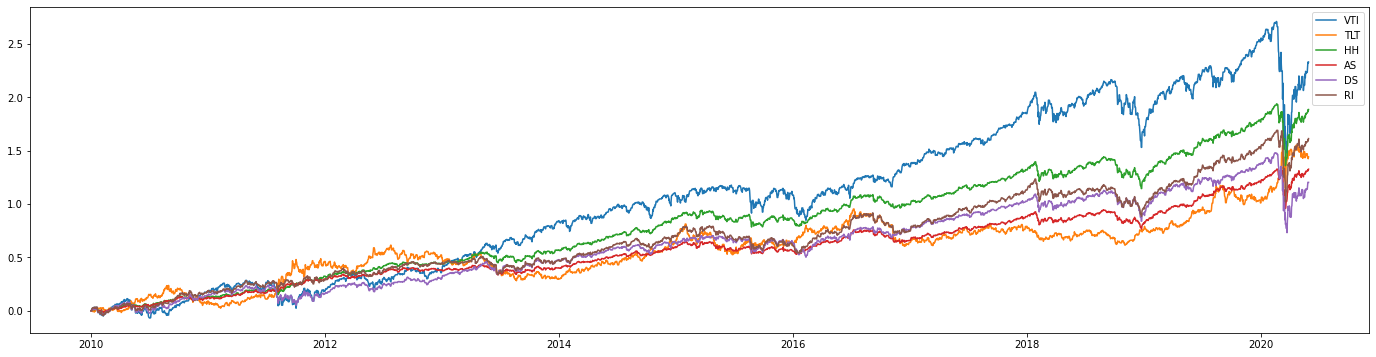

In [10]:
plt.figure(figsize=(24, 6))

for name, strategy in dict_strategies.items():
    series_wealth = pd.Series(strategy.wealth.wealth, index=universe.bars)
    plt.plot(series_wealth, label=name)

plt.legend()
plt.show()

In [11]:
from epymetheus.metrics import MaxDrawdown, SharpeRatio

dict_sharpe = {
    name: strategy.evaluate(SharpeRatio()) for name, strategy in dict_strategies.items()
}
dict_maxdd = {
    name: strategy.evaluate(MaxDrawdown()) for name, strategy in dict_strategies.items()
}

In [12]:
for name, sharpe in dict_sharpe.items():
    print(f"{name:<4}", sharpe)

VTI  0.029510870440810147
TLT  0.029247940345086588
HH   0.05194077037272299
AS   0.05345709606786763
DS   0.027052792345459056
RI   0.0383006234421881


In [13]:
for name, maxdd in dict_maxdd.items():
    print(f"{name:<4}", maxdd)

VTI  -1.2979093417704637
TLT  -0.40079625872041813
HH   -0.5803881993909943
AS   -0.36870933662394123
DS   -0.7475602201958065
RI   -0.6688661796534237
